<a href="https://colab.research.google.com/github/hyeonji-cho/Pytorch_Textbook/blob/main/ch5_3%2C4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.3.1 특성 추출

#### 라이브러리 호출

In [1]:
import os
import time
import copy
import glob
import cv2  # OpenCV 라이브러리
import shutil

import torch
import torchvision  # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models  # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

#### 데이터 불러오기

In [2]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [3]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

#### 이미지 데이터 전처리 방법 정의

In [4]:
data_path = 'catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),  # 256x256 크기로 조정
                    transforms.RandomResizedCrop(224),  # 이미지를 임의로 자르고 크기를 조절하여 최종적으로 224x224 크기의 이미지를 생성
                    transforms.RandomHorizontalFlip(),  # 이미지를 랜덤하게 수평으로 뒤집음
                    transforms.ToTensor(),  # 이미지 데이터를 텐서로 변환
                ])
train_dataset = torchvision.datasets.ImageFolder(  # 데이터로더가 데이터를 불러올 대상과 방법 정의
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(  # 데이터로더 - 데이터를 불러오는 부분
    train_dataset,  # 데이터셋 지정
    batch_size=32,  # 한 번에 불러올 데이터양
    num_workers=8,  # 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지
    shuffle=True  # 데이터를 무작위로 섞을 것인지
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### 학습에 사용될 이미지 출력

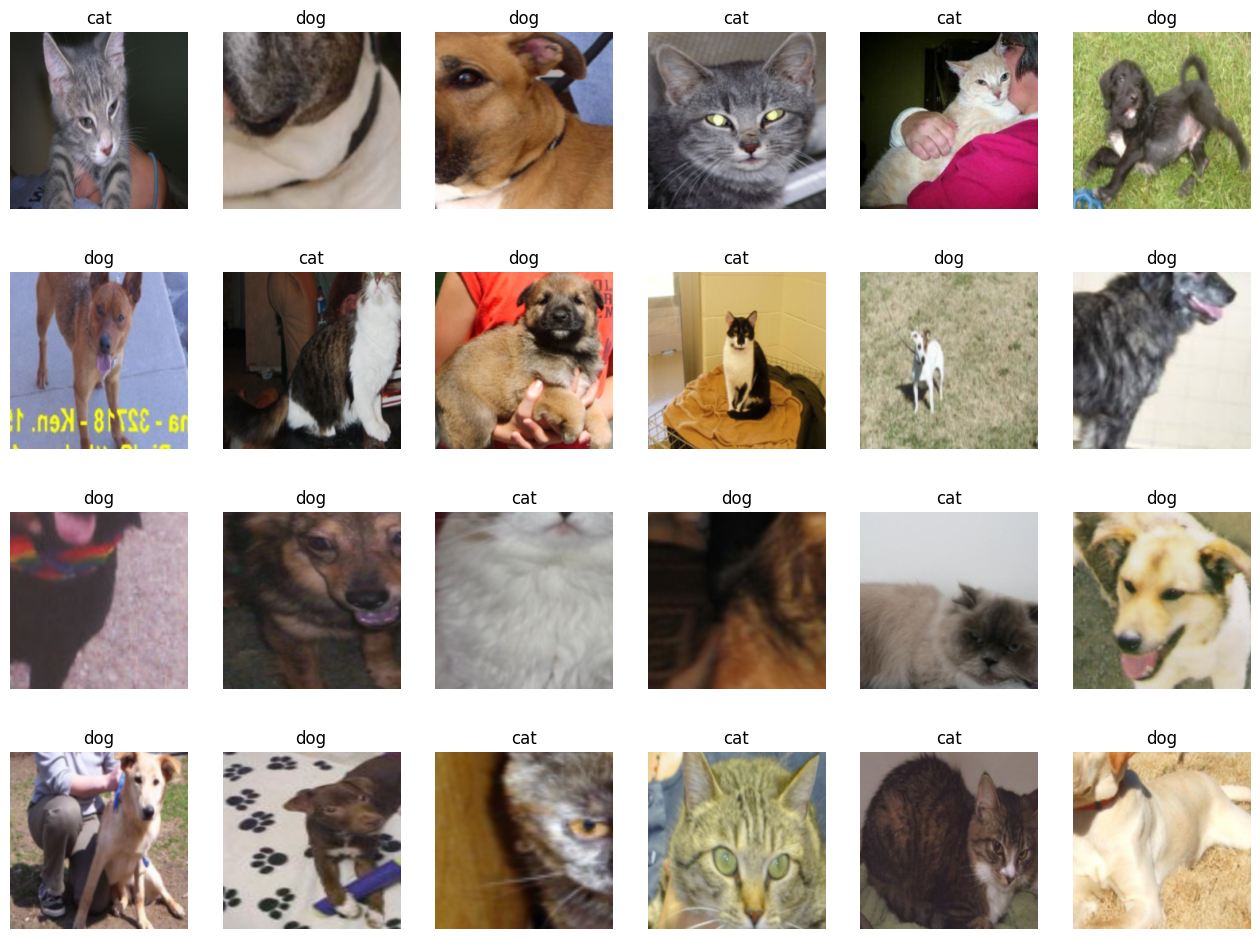

In [5]:
import numpy as np

# train_loader로부터 배치를 가져옴 (데이터를 하나씩 꺼내옴)
data_iter = iter(train_loader)
samples, labels = next(data_iter)

classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))  # 생성된 figure의 크기 지정

# 이미지 데이터 시각화
for i in range(24):  # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4,6,i+1)  # 4x6 그리드에 i+1번째 서브플롯 추가
    a.set_title(classes[labels[i].item()])  # 서브플롯의 제목 설정 (이미지의 클래스 레이블로)
    a.axis('off')  # 축 숨김
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))  # 이미지 데이터 시각화, (세로, 가로, 채널)

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

#### 사전 훈련된 모델 내려받기

In [6]:
resnet18 = models.resnet18(pretrained=True)  # 사전 학습된 가중치를 사용하겠음

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


#### 사전 훈련된 모델의 파라미터 학습 유무 지정

In [7]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False  # 역전파 중 파라미터들에 대한 변화를 계산할 필요 없음

set_parameter_requires_grad(resnet18)  # resnet18 모델의 파라미터를 역전파 중 동결시킴

#### ResNet18에 완전연결층 추가

In [8]:
# ResNet-18 모델의 마지막 합성곱층의 출력 크기 = 512
resnet18.fc = nn.Linear(512, 2)  # 클래스가 2개

#### 모델의 파라미터 값 확인

In [9]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0069,  0.0396,  0.0007,  ...,  0.0143, -0.0342,  0.0208],
        [-0.0027,  0.0282, -0.0139,  ...,  0.0064, -0.0278, -0.0253]])
fc.bias tensor([-0.0151, -0.0194])


#### 모델 객체 생성 및 손실 함수 정의

In [10]:
model = models.resnet18(pretrained = True)  # 모델의 객체 생성

for param in model.parameters():  # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():  # 완전연결층 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()  # 손실 함수 정의
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 모델 학습을 위한 함수 생성

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()  # 현재 시간 기록
    acc_history = []  # 정확도 기록 리스트
    loss_history = []  # 손실 기록 리스트
    best_acc = 0.0  # 최고 정확도 초기화

    for epoch in range(num_epochs):  # 에포크만큼 반복
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0  # 에포크마다 손실 초기화
        running_corrects = 0  # 에포크마다 정확도 초기화

        for inputs, labels in dataloaders:  # 데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)  # 입력 데이터를 지정된 장치로 이동
            labels = labels.to(device)  # 레이블 데이터를 지정된 장치로 이동

            model.to(device)  # 모델을 지정된 장치로 이동
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # 손실 계산
            _, preds = torch.max(outputs, 1) # preds : 두 번째 반환값인 인덱스 저장
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)  # 현재 미니배치의 손실 값 * 배치 크기 = 현재 미니배치에 대한 총 손실
            running_corrects += torch.sum(preds == labels.data)  # 정확한 예측 수 누적

        epoch_loss = running_loss / len(dataloaders.dataset)  # 평균 손실 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))  # 모델 상태 저장
        print()

    time_elapsed = time.time() - since  # 걸린 시간 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  # 훈련 시간 출력
    print('Best Acc: {:4f}'.format(best_acc))  # 최고 정확도 출력
    return acc_history, loss_history  # 정확도와 손실 기록 리스트 반환

#### 파라미터 학습 결과를 옵티마이저에 전달

In [12]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)  # 파라미터 학습 결과를 저장
        print("\t",name)

optimizer = optim.Adam(params_to_update)  # 학습 결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


#### 모델 학습

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # 손실 함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5567 Acc: 0.7169

Epoch 1/12
----------
Loss: 0.3796 Acc: 0.8494

Epoch 2/12
----------
Loss: 0.3092 Acc: 0.8961

Epoch 3/12
----------
Loss: 0.2630 Acc: 0.9299

Epoch 4/12
----------
Loss: 0.2523 Acc: 0.9091

Epoch 5/12
----------
Loss: 0.2471 Acc: 0.9091

Epoch 6/12
----------
Loss: 0.2432 Acc: 0.9039

Epoch 7/12
----------
Loss: 0.2171 Acc: 0.9273

Epoch 8/12
----------
Loss: 0.2232 Acc: 0.9065

Epoch 9/12
----------
Loss: 0.2284 Acc: 0.9039

Epoch 10/12
----------
Loss: 0.2090 Acc: 0.9169

Epoch 11/12
----------
Loss: 0.2094 Acc: 0.9065

Epoch 12/12
----------
Loss: 0.1771 Acc: 0.9377

Training complete in 0m 36s
Best Acc: 0.937662


#### 테스트 데이터 호출 및 전처리

In [14]:
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


#### 테스트 데이터 평가 함수 생성

In [15]:
def eval_model(model, dataloaders, device):
    since = time.time()  # 시작 시간 기록
    acc_history = []  # 정확도 기록 리스트 초기화
    best_acc = 0.0  # 최고 정확도 초기화

    saved_models = glob.glob('catanddog/' + '*.pth')  # 'catanddog/' 경로에서 pth 확장자를 가진 파일 목록 가져오기
    saved_models.sort()  # 불러온 .pth 파일들을 정렬
    print('saved_model', saved_models)  # 불러온 모델 경로 출력

    for model_path in saved_models:  # 각 불러온 모델에 대해 반복
        print('Loading model', model_path)  # 현재 불러온 모델 경로 출력

        model.load_state_dict(torch.load(model_path))  # 모델의 상태 불러오기
        model.eval()  # 평가 모드로 설정
        model.to(device)  # 지정된 장치로 모델 이동
        running_corrects = 0  # 정확하게 예측된 샘플 수 초기화

        for inputs, labels in dataloaders:  # 데이터로더에서 전달된 데이터에 대해 반복
            inputs = inputs.to(device)  # 입력 데이터를 지정된 장치로 이동
            labels = labels.to(device)  # 레이블 데이터를 지정된 장치로 이동

            with torch.no_grad():  # 그래디언트 계산 비활성화
                outputs = model(inputs)  # 모델로부터 예측값 얻기

            _, preds = torch.max(outputs.data, 1)  # 예측 클래스 결정
            preds[preds >= 0.5] = 1  # 0.5 이상의 값은 1로 설정
            preds[preds < 0.5] = 0  # 0.5 미만의 값은 0으로 설정
            running_corrects += preds.eq(labels).int().sum()  # 정확하게 예측된 샘플 수 누적

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # 정확도 계산
        print('Acc: {:.4f}'.format(epoch_acc))  # 현재 모델의 정확도 출력

        if epoch_acc > best_acc:  # 현재 정확도가 최고 정확도보다 높으면
            best_acc = epoch_acc  # 최고 정확도 갱신

        acc_history.append(epoch_acc.item())  # 정확도 기록 리스트에 현재 정확도 추가
        print()

    time_elapsed = time.time() - since  # 걸린 시간 계산
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))  # 검증 시간 출력
    print('Best Acc: {:4f}'.format(best_acc))  # 최고 정확도 출력

    return acc_history  # 정확도 기록 리스트 반환


#### 테스트 데이터를 평가 함수에 적용

In [16]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.8980

Loading model catanddog/01.pth
Acc: 0.9184

Loading model catanddog/02.pth
Acc: 0.9184

Loading model catanddog/03.pth
Acc: 0.9388

Loading model catanddog/04.pth
Acc: 0.9286

Loading model catanddog/05.pth
Acc: 0.9490

Loading model catanddog/06.pth
Acc: 0.9082

Loading model catanddog/07.pth
Acc: 0.9286

Loading model catanddog/08.pth
Acc: 0.9184

Loading model catanddog/09.pth
Acc: 0.9490

Loading model catanddog/10.pth
Acc: 0.9286

Loading model catanddog/11.pth
Acc: 0.9286

Loading model catanddog/12.pth
Acc: 0.9388

Validation complete in 0m 8s
Best Acc: 0.948980


#### 훈련과 테스트 데이터의 정확도를 그래프로 확인

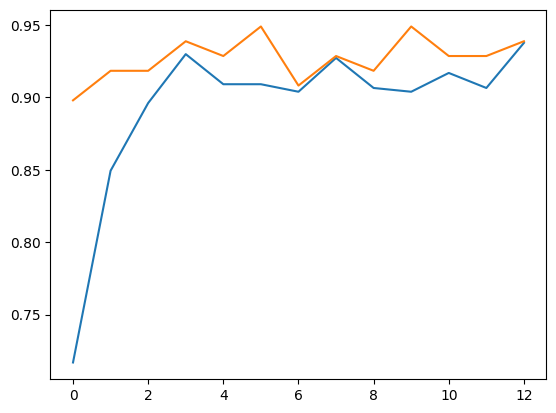

In [17]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

#### 훈련 데이터의 오차에 대한 그래프 확인

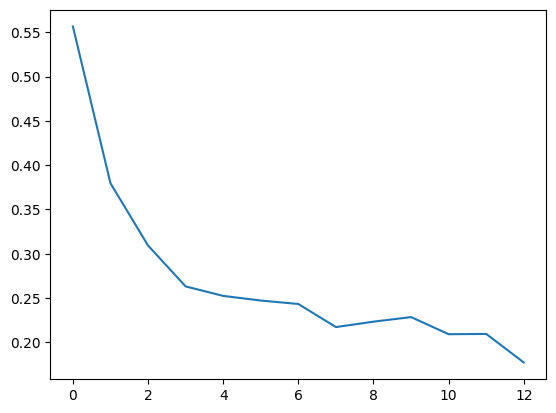

In [18]:
plt.plot(train_loss_hist)
plt.show()

### 실제로 데이터를 잘 예측하는지 확인

#### 예측 이미지 출력을 위한 전처리 함수

In [19]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()  # 기울기에 영향을 주지 않는 기존 텐서를 복사한 새로운 텐서 생성
                                           # tensor.detach() : 텐서를 계산 그래프에서 분리. 분리된 텐서는 역전파를 통해 그래디언트를 계산하지 않는다.
    image=image.transpose(1,2,0) # 이미지 차원을 변경하여 채널을 마지막으로 이동
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  # 이미지를 정규화된 값으로 변환
    image=image.clip(0,1)  # image 데이터를 0과 1 사이의 값으로 제한하겠다 - 클리핑
    return image

#### 개와 고양이 예측 결과 출력

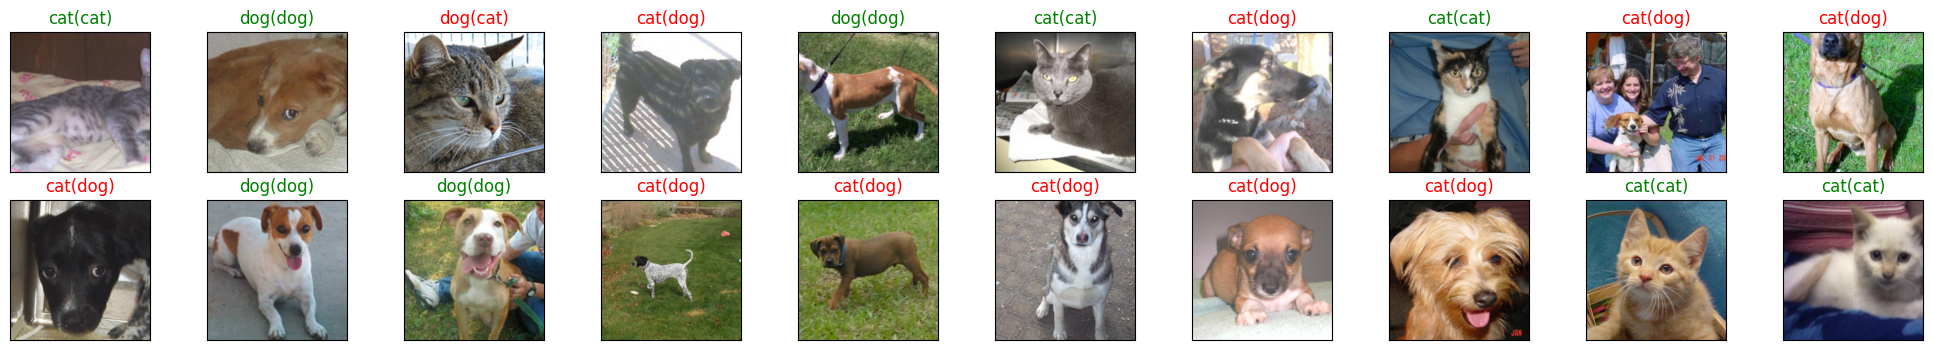

<Figure size 640x480 with 0 Axes>

In [20]:
classes = {0:'cat', 1:'dog'}  # 개와 고양이 두 개에 대한 레이블

dataiter=iter(test_loader)  # 테스트 데이터셋 가져오기
images,labels=next(dataiter)  # 테스트 데이터셋에서 이미지와 레이블을 분리하여 가져오기

output = model(images)  # 모델을 사용하여 출력 예측값 계산
_, preds = torch.max(output, 1)  # 가장 높은 확률을 가진 클래스의 인덱스 찾기

fig = plt.figure(figsize=(25, 4))  # 시각화할 그림의 크기 설정
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  # 행의 수, 열의 수, 인덱스, tick삭제
    plt.imshow(im_convert(images[idx]))  # 위에서 정의한 이미지 출력 함수
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),  # 서브 플롯 제목 설정, 예측 클래스와 실제 클래스 표시
                 color=("green" if preds[idx]==labels[idx] else "red"))  # preds[idx].item() 값이 0-고양이, 1-개, 정확한 예측이면 녹색, 그렇지 않으면 빨간색으로 표시
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)  # 서브 플롯의 간격 조정

# 5.4.1 특성 맵 시각화

#### 필요한 라이브러리 호출

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 설명 가능한 네트워크 생성
- 13개의 합성곱층과 2개의 완전연결층으로 구성된 네트워크 생성
- 렐루 활성화 함수 사용

In [22]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),  # 입력채널, 출력채널, 커널, 편향사용X, (64, 222, 222)
            nn.BatchNorm2d(64),  # 입력 채널이 64개인 2D 이미지 데이터에 대한 배치 정규화
            nn.ReLU(inplace=True),  # 활성화 함수 통과, 기존의 데이터를 연산의 결괏값으로 대체한다
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 절반 (64, 111, 111)

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 절반 (128, 56, 56)

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 절반 (256, 28, 28)

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 절반 (512, 14, 14)

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 이미지 크기 절반 (512, 7, 7)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # (512, 7, 7)
        x = x.view(-1, 512)  # nn.Linear(512, 512)를 거치기 위해 (N,512)으로 맞춰줌
        x = self.classifier(x)
        return F.log_softmax(x)  # 신경망 말단의 결괏값들을 확률 개념으로 해석

#### 모델 객체화

In [23]:
model=XAI()  # model이라는 이름의 객체 생성
model.cpu() # 모델에 입력되는 이미지를 넘파이로 받아오는 부분때문에 CPU를 사용하도록 지정하였습니다
model.eval() # 테스트 데이터에 대한 모델 평가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

#### 특성 맵을 확인하기 위한 클래스 정의

In [24]:
class LayerActivations:
    features=[]  # 레이어 활성화 값을 저장할 리스트를 초기화합니다.
    def __init__(self, model, layer_num):  # 클래스 생성자입니다. 모델과 레이어 번호를 받습니다.
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)  # 선택한 레이어에 대한 forward hook을 등록합니다.

    def hook_fn(self, module, input, output):  # forward hook이 실행될 때 호출될 함수입니다.
        output = output  # 출력을 저장합니다.
        #self.features = output.to(device).detach().numpy()  # 출력을 디바이스에 전송하고 NumPy 배열로 변환하여 활성화 값 리스트에 저장합니다.
        self.features = output.detach().numpy()  # 출력을 NumPy 배열로 변환하여 활성화 값 리스트에 저장합니다.

    def remove(self):  # 등록된 hook을 제거하는 함수입니다.
        self.hook.remove()  # 등록된 hook을 제거합니다.


#### 이미지 호출

Saving cat.jpg to cat.jpg
torch.Size([1, 3, 100, 100])


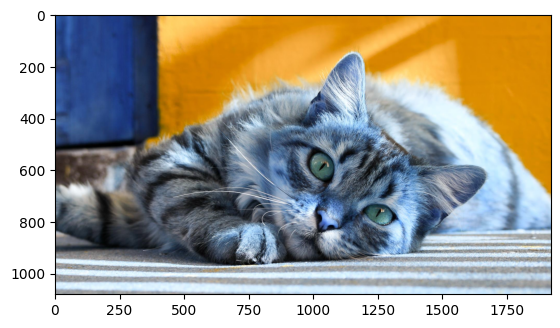

In [25]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # chap05/data/cat.jpg 데이터 불러오기

img=cv2.imread("cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)  # 이미지 파일, 변경될 이미지 크기, 보간법
img = ToTensor()(img).unsqueeze(0)  # 이미지데이터 -> 텐서 -> 인덱스 0에 새로운 차원을 추가 (이 경우에는 배치 차원을 추가)

print(img.shape)

#### Conv2d 특성 맵 확인

In [26]:
result = LayerActivations(model.features, 0)  # 모델의 특성을 가진 모델의 첫 번째 레이어의 활성화 추적기를 생성합니다.
                                                # (0번째 Conv2d 레이어의 특성 맵을 확인하기 위해)
model(img)  # 모델에 이미지를 전달하여 순전파를 수행합니다.
activations = result.features  # 활성화 추적기에서 추출된 특성 맵을 가져옵니다.
                                # 이는 0번째 Conv2d 레이어를 통과한 후의 활성화 값입니다.

<ipython-input-22-cbf129bfc90e>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)  # 신경망 말단의 결괏값들을 확률 개념으로 해석


- 이 코드는 주어진 이미지를 모델에 전달하고, 특정 레이어의 활성화 값을 추출하는 데 사용됩니다. 먼저, 모델의 첫 번째 레이어에 대한 활성화를 추적하기 위해 LayerActivations 클래스를 사용합니다. 그런 다음, 이미지를 모델에 전달하여 순전파를 수행하고, 지정한 레이어의 활성화 값을 가져옵니다. 이렇게 함으로써 해당 레이어의 특성 맵을 추출할 수 있습니다.

#### 특성 맵 시각화

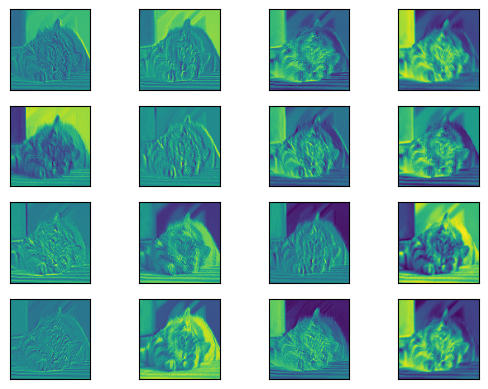

<Figure size 1200x800 with 0 Axes>

In [27]:
fig, axes = plt.subplots(4, 4)  # 4x4 그리드의 하위 그래프를 생성합니다.
fig = plt.figure(figsize=(12, 8))  # 그림 크기를 설정합니다.
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)  # 하위 그래프의 간격을 조정합니다.
for row in range(4):  # 4개의 행에 대해 반복합니다.
    for column in range(4):  # 4개의 열에 대해 반복합니다.
        axis = axes[row][column]  # 현재 위치의 축을 가져옵니다.
        axis.get_xaxis().set_ticks([])  # x축 눈금을 비활성화합니다.
        axis.get_yaxis().set_ticks([])  # y축 눈금을 비활성화합니다.
        axis.imshow(activations[0][row*10+column])  # 활성화 특성 맵을 해당 위치에 표시합니다.
plt.show()  # 그림을 표시합니다.

#### 20번째 계층에 대한 특성 맵

In [28]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

<ipython-input-22-cbf129bfc90e>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)  # 신경망 말단의 결괏값들을 확률 개념으로 해석


#### 특성 맵 시각화

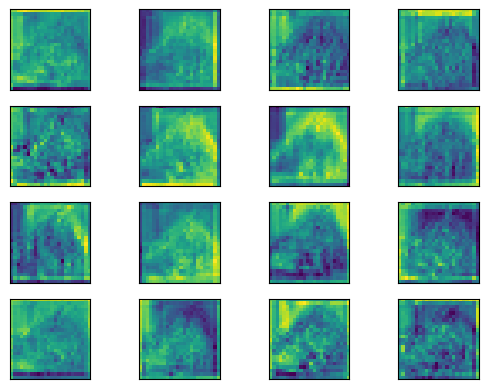

<Figure size 1200x800 with 0 Axes>

In [29]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

#### 40번째 계층에 대한 특성 맵

In [30]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-22-cbf129bfc90e>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)  # 신경망 말단의 결괏값들을 확률 개념으로 해석


#### 특성 맵 시각화

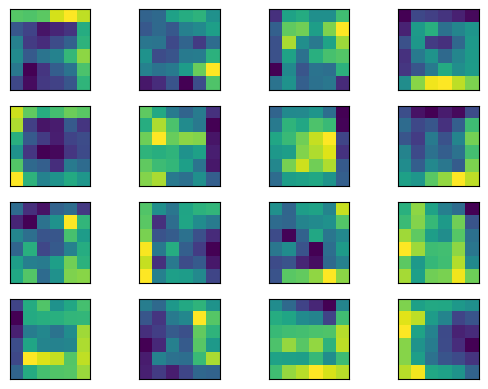

<Figure size 1200x800 with 0 Axes>

In [31]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()